<a href="https://colab.research.google.com/github/YanivRefaelovich/ML-Projects/blob/master/IEEE%20Fraud%20Detection/IEEE_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import numpy as np 
import pandas as pd 
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import xgboost as xgb
from xgboost import plot_importance

os.chdir('drive/My Drive/ML projects/IEEE Fraud Detection')
print(os.listdir())


['IEEE Fraud Detection.ipynb', 'Submissions', 'Data', 'IEEE Fraud Detection_2.ipynb']


In [0]:
train_identity = pd.read_csv('Data/train_identity.csv')
train_transaction = pd.read_csv('Data/train_transaction.csv')
test_identity = pd.read_csv('Data/test_identity.csv')
test_transaction = pd.read_csv('Data/test_transaction.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')

In [0]:
def basic_eda(df):
#     print("-----------HEAD----------------")
#     print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)

*Basic EDA*

In [0]:
print('=========================train_identity=========================')
basic_eda(train_identity)
print('=========================train_transaction=========================')
basic_eda(train_transaction)
print('=========================test_identity=========================')
basic_eda(test_identity)
print('=========================test_transaction=========================')
basic_eda(test_transaction)
print('=========================sample_submission=========================')
basic_eda(sample_submission)

In [9]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [11]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
test_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [13]:
print(train_identity.shape, train_transaction.shape)

train_unique_ID = pd.concat([train_identity['TransactionID'], train_transaction['TransactionID']], axis=0).unique()
train_unique_ID.shape

(144233, 41) (590540, 394)


(590540,)

In [14]:
print(test_identity.shape, test_transaction.shape)

test_unique_ID = pd.concat([test_identity['TransactionID'], test_transaction['TransactionID']], axis=0).unique()
test_unique_ID.shape

(141907, 41) (506691, 393)


(506691,)

* All ID's are present in 'transaction' dataframe
* in the 'identity' data frame - only part of it

*Plan*
- check what types of data we have
- check how many missing values we have
- choose what features to use base on test with less than 30% missing values
- deal with missing values
- dealing with outliers
- label encoding for categorical values
- XGB


===================test_transaction======================

usnig features with less than 30.0% missing values

 selected features with less than 30.0 % missing values are: 

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=200)


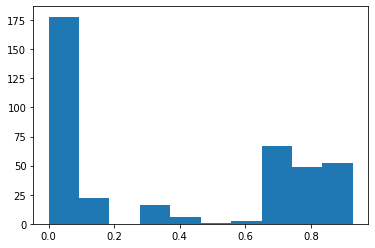

In [15]:
print('===================test_transaction======================\n')

# taking subset because dataframe is too large
plt.hist(test_transaction.isnull().sum()/test_transaction.shape[0]);

missing_thresh = 0.3
print('usnig features with less than ' +  str(missing_thresh*100) + '% missing values')
selected_columns = test_transaction.columns[test_transaction.isnull().sum()/test_transaction.shape[0]<missing_thresh]
X_transaction_test = test_transaction[selected_columns]

print('\n selected features with less than ' + str(missing_thresh*100) + ' % missing values are: \n')
print(selected_columns)


===================train_transaction======================

all features also in train have less that 30% missing values


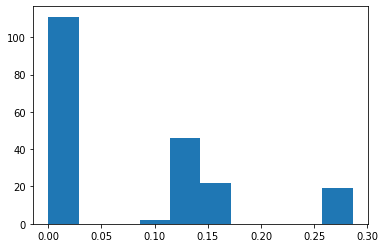

In [16]:
print('===================train_transaction======================\n')

# taking selected features in train

X_transaction = train_transaction[selected_columns]
y = train_transaction['isFraud']

X_transaction.head()
plt.hist(X_transaction.isnull().sum()/X_transaction.shape[0]);

print('all features also in train have less that 30% missing values')


In [17]:
del  test_transaction, train_transaction
gc.collect()

6078

In [18]:
types = X_transaction.dtypes
types.loc[(types!='int64') & (types!='float64')]


print('number of numeric variables:', types.loc[(types=='int64') | (types=='float64')].shape[0],'\n')
print(types.loc[(types=='int64') | (types=='float64')].index)
print('\nnumber of categorical variables:', types.loc[(types!='int64') & (types!='float64')].shape[0],'\n')
print(types.loc[(types!='int64') & (types!='float64')].index)


number of numeric variables: 196 

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card5', 'addr1', 'addr2', 'C1',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=196)

number of categorical variables: 4 

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain'], dtype='object')


In [0]:
numeric_features = X_transaction.loc[:, (types.values=='int64') | (types.values=='float64')]
categoric_features = X_transaction.loc[:, (types.values!='int64') & (types.values!='float64')]

In [0]:
# gc.collect()
# corr = np.corrcoef(numeric_features.values, rowvar=False)
# corr2 = numeric_features.corr(method='pearson')

# taking subset because dataframe is too large
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

# for train_index, test_index in sss.split(train_transaction, train_transaction['isFraud']):
#     X =  train_transaction.iloc[test_index,:]

# plt.hist(X.isnull().sum()/X.shape[0]);
# # removing features with more than half missing values

# y = numeric_features['isFraud']
# p_value = []
# for col in numeric_features.columns:
#     x = numeric_features[col]
#     t2, p2 = stats.ttest_ind(x[y==0], x[y==1], nan_policy='omit')
#     p_value.extend([p2])
            
# plt.plot(p_value,'.')
# plt.title('T test results between classes');
# plt.xlabel('#Feature');
# plt.ylabel('P_value');

# plt.figure()
# plt.hist(p_value)
# plt.title('T test results between classes');
# plt.xlabel('#P_value');

In [21]:
# removing outliers from numeric features in train set
gc.collect()

z = np.abs(stats.zscore(numeric_features))

a = np.sum(z>2, axis=1)

# outliers will be samples with more than 10 features that their Z score grater than 2
outliers = np.where( np.sum(z>2, axis=1) > 10)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [0]:
# removing outliers
X_transaction = X_transaction.drop(outliers, axis=0)
y = y.drop(outliers, axis=0)


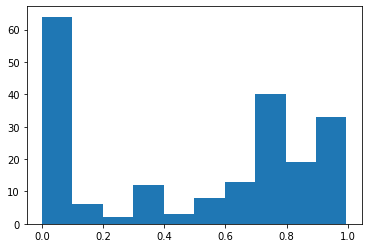

In [23]:
zeros_counts = (X_transaction==0).sum()/X_transaction.shape[0]
plt.hist(zeros_counts.values)
columns_to_drop = zeros_counts.index[zeros_counts>0.95].values.tolist()

In [0]:
# filling up the gaps in train set
gc.collect()

for i in range(X_transaction.shape[1]):
    
    if (types.values[i]=='int64') | (types.values[i]=='float64'):
        X_transaction.iloc[:, i] = X_transaction.iloc[:, i].fillna(X_transaction.iloc[:, i].mean())
    else:
        X_transaction.iloc[:, i] = X_transaction.iloc[:, i].fillna(X_transaction.iloc[:, i].mode().values[0])


In [0]:
# filling up the gaps in test set
gc.collect()

for i in range(X_transaction_test.shape[1]):
    
    if (types.values[i]=='int64') | (types.values[i]=='float64'):
        X_transaction_test.iloc[:, i] = X_transaction_test.iloc[:, i].fillna(X_transaction_test.iloc[:, i].mean())
    else:
        X_transaction_test.iloc[:, i] = X_transaction_test.iloc[:, i].fillna(X_transaction_test.iloc[:, i].mode().values[0])


In [26]:
print('number of missing values in train: ', X_transaction.isnull().sum().sum())
print('number of missing values in test: ', X_transaction_test.isnull().sum().sum())


number of missing values in train:  0
number of missing values in test:  0


In [27]:
# label encoder train
le = LabelEncoder()

X_transaction.loc[:, (types.values!='int64') & (types.values!='float64')] = X_transaction.loc[:, (types.values!='int64') & (types.values!='float64')].apply(lambda col: le.fit_transform(col))

# label encoder test
le = LabelEncoder()

X_transaction_test.loc[:, (types.values!='int64') & (types.values!='float64')] = X_transaction_test.loc[:, (types.values!='int64') & (types.values!='float64')].apply(lambda col: le.fit_transform(col))


gc.collect()

0

In [0]:
columns_to_drop.extend(['TransactionID', 'TransactionDT'])

X_transaction.drop(['TransactionID', 'TransactionDT',], axis=1, inplace=True)
X_transaction_test.drop(['TransactionID', 'TransactionDT',], axis=1, inplace=True)

In [0]:
gc.collect()

params = {'max_depth':10,
          'learning_rate':0.1,
#           'verbosity':0,
          'objective': 'binary:logistic',
          'n_estimators':100,
          'n_jobs':-1,
          'scale_pos_weight':2,
          'reg_alpha': 0.5,
          'reg_lambda': 0.5,
#           'gamma': 0.0
         }


xg = xgb.XGBClassifier(**params)
K=5
SKF = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)

y_pred = np.zeros((X_transaction_test.shape[0]))

for train_inds, val_inds in SKF.split(X_transaction, y):
    
    gc.collect()
    xg.fit(X_transaction.iloc[train_inds, :], y.iloc[train_inds],
          eval_metric='auc',
          eval_set=[(X_transaction.iloc[val_inds, :], y.iloc[val_inds])],
          verbose=1)

    # predictiong test
    k_y_pred = xg.predict_proba(X_transaction_test)
    
    y_pred+=k_y_pred[:, 1]/K

    
    

[0]	validation_0-auc:0.854044
[1]	validation_0-auc:0.860145
[2]	validation_0-auc:0.861428
[3]	validation_0-auc:0.871998
[4]	validation_0-auc:0.875898
[5]	validation_0-auc:0.878717
[6]	validation_0-auc:0.880341
[7]	validation_0-auc:0.881736
[8]	validation_0-auc:0.883178
[9]	validation_0-auc:0.884811
[10]	validation_0-auc:0.887113
[11]	validation_0-auc:0.889569
[12]	validation_0-auc:0.891342
[13]	validation_0-auc:0.892574
[14]	validation_0-auc:0.893946
[15]	validation_0-auc:0.895465
[16]	validation_0-auc:0.896872
[17]	validation_0-auc:0.898966
[18]	validation_0-auc:0.899962
[19]	validation_0-auc:0.902197
[20]	validation_0-auc:0.904053
[21]	validation_0-auc:0.905353
[22]	validation_0-auc:0.907023
[23]	validation_0-auc:0.908029
[24]	validation_0-auc:0.909212
[25]	validation_0-auc:0.910869
[26]	validation_0-auc:0.91232
[27]	validation_0-auc:0.913272
[28]	validation_0-auc:0.91491
[29]	validation_0-auc:0.916392
[30]	validation_0-auc:0.917405
[31]	validation_0-auc:0.919652
[32]	validation_0-au

In [0]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['isFraud']=y_pred
submission.to_csv('submission5.csv',index=False)

In [0]:
X_transaction.shape